In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import os
import abc
import pyaml

import typing as T

from dataclasses import dataclass
from pathlib import Path
from imageio import imread
from skimage import filters
from skimage.transform import rescale
from skimage.util import view_as_windows
from scipy import stats
from tqdm.auto import tqdm
from matplotlib import pyplot as plt


In [3]:
from blob_detector import utils
from blob_detector.core.pipeline import Pipeline
from blob_detector.core.binarizers import BinarizerType

In [4]:

@dataclass
class Args:
    root:               Path      = Path("/home/korsch/Data/DATASETS/moths")
    location:           str       = "eu_moths/uncropped/ORIGINAL"
    
    pad:                bool      = False
    extensions:         tuple     = ("jpg", "png", "jpeg")
    
    sigma:              float     = 5
    equalize:           bool      = True
    scale:              float     = 0.1
    min_size:           float     = 800
    block_size_scale:   float     = 0.1
    enlarge:            float     = 0.01
    
        
    kernel_size:        int       = 5
    dilate_iterations:  int       = 1
    
    # high_pass otsu gauss_local
    thresholding:       str       = "high_pass"
    
    
    def __str__(self):
        return pyaml.dump(dict(Arguments=self.__dict__), sort_dicts=False)
    


In [5]:
def _is_image(im_name, extensions):
    return any([im_name.lower().endswith(ext.lower()) for ext in extensions])

def get_images(path, extensions=[], sort=True):
    result = []
    
    for root, dirnames, fnames in os.walk(path):
        
        result.extend([Path(root) / fname for fname in fnames if _is_image(fname, extensions)])

    if sort:
        result = sorted(result)
    
    return result

def random_color(rnd: np.random.RandomState = None):
    rnd = rnd or np.random.RandomState()
    c = rnd.randint(0, 255, size=(3,))
    return utils.int_tuple(c)

def histogram(im: np.ndarray, bins: int = 256, cumulative: bool = False):
    hist, edges = np.histogram(im, bins=bins, density=False)
    hist = hist / np.multiply(*im.shape)
    return np.cumsum(hist) if cumulative else hist


5.1827537e-05 0.0028296877 0.924336
10.0 31


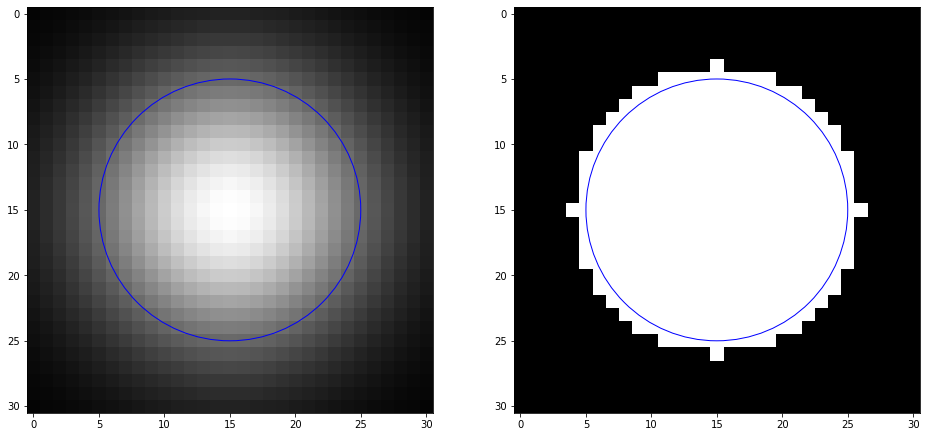

In [6]:
size = 31
eps = 1 / size**2
sigma = (size - 1) / 4

im = np.zeros((size, size), dtype=np.float32)
im[size//2, size//2] = 1.0

im2 = utils._gaussian(im, sigma=sigma)
print(im2.min(), im2.max(), im2.sum())
im2 /= im2.sum()
binary = (im2 > eps).astype(np.float32)

fig, axs = plt.subplots(ncols=2, figsize=(16,9))

axs[0].imshow(im2, vmin=0.0, vmax=im2.max(), cmap=plt.cm.gray)
axs[1].imshow(binary, vmin=0.0, vmax=1.0, cmap=plt.cm.gray)

contours, _ = cv2.findContours((binary * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ax: plt.Axes = axs[1]
for cont in contours:
    mid, (r0, r1), angle = cv2.fitEllipse(cont)
    radius = min(r0, r1) // 2
    print(radius, size)
    axs[1].add_patch(plt.Circle(mid, radius, fill=False, edgecolor="blue"))
    axs[0].add_patch(plt.Circle(mid, radius, fill=False, edgecolor="blue"))

plt.show()
plt.close()

In [7]:
def simple_detector(im: np.ndarray):
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 200


    # Filter by Area.
#     params.filterByArea = True
#     params.minArea = 1500

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(im)
    print(keypoints)
    _im = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)
    im_with_keypoints = cv2.drawKeypoints(_im, keypoints, np.array([]), 
                                          random_color(), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    ax.imshow(im_with_keypoints)
    
    plt.show()
    plt.close()

In [20]:
def _crop(im, rel_bbox):
    (x0,y0), (x1,y1) = rel_bbox
    h, w = im.shape
    return im[int(y0*h):int(y1*h), int(x0*w):int(x1*w)]

def _split_bbox(im: np.ndarray, bboxes):

In [131]:
def _imshow(spec, im, *, title=None, cmap=plt.cm.gray):
    ax = plt.subplot(spec)
    #ax.axis("off")
    ax.imshow(im, cmap=cmap)
    if title is not None:
        ax.set_title(title)
    return ax


def _plot_detections(im: np.ndarray, bboxes, inds, means_stds = None):
    
    
    im_pos = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)
    im_neg = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)

    for j, (bbox, (mean, std, ttest_res)) in enumerate(zip(bboxes, means_stds)):
        xy0, xy1 = bbox
        c = random_color()
        _bbox_im = im_pos if j in inds else im_neg

        cv2.rectangle(_bbox_im, xy0, xy1, c, 2)
        cv2.putText(_bbox_im,    
                    text=f"{mean:.2f} | {std:.2f}",
                    org=(xy0[0], int(xy0[1] - 5)),
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=.7,
                    color=(0,0,255),
                    thickness=2,
                   )
    return im_pos, im_neg

def main(args: Args, N: int = 5):
    image_folder = Path(args.root) / args.location
    ims = get_images(image_folder, extensions=args.extensions)
    ims = np.random.choice(ims, size=N, replace=False)
    
    thresholding = {
        t.name.lower(): t for t in BinarizerType
    }.get(args.thresholding)
    
    print(thresholding)
    
    bbox_splitter = Splitter()
    
    pipeline = Pipeline()
    pipeline.add_operation(bbox_splitter.set_image)
    pipeline.rescale(min_size=args.min_size, 
                     min_scale=args.scale)
    pipeline.preprocess(equalize=args.equalize, 
                        sigma=args.sigma)
    pipeline.binarize(type=thresholding,
                      block_size_scale=args.block_size_scale,
                      do_padding=args.pad,
                      sigma=5, 
                      window_size=30
                 )
    pipeline.remove_border()
    pipeline.open_close(kernel_size=args.kernel_size, 
                        iterations=args.dilate_iterations)
    pipeline.detect()
    pipeline.add_operation(bbox_splitter.split)
    pipeline.bbox_filter(enlarge=args.enlarge)
    
    for i, im_path in enumerate(tqdm(ims)):
        orig = cv2.imread(str(im_path), cv2.IMREAD_COLOR)
        
        orig = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        print(orig.shape)

        im0, im, bin_im, post_bin_im, *_, detections = pipeline(orig, return_all=True)

        bboxes, inds, means_stds = detections
        
        im2, im3 = _plot_detections(im, *detections)
    
#         for j in inds:
#             _split_bbox(bboxes[j], orig, rescale_size=im.shape, detector=detector, bin_image=post_bin_im)

        grid = plt.GridSpec(nrows=3, ncols=6)
        fig = plt.figure(figsize=(16, 9))
        
        _imshow(grid[0, 0:2],          im,             title="Pre-bin input")
        _imshow(grid[0, 2:4],          bin_im,         title="Binarized")
        _imshow(grid[0, 4:6],          post_bin_im,    title="Binarized (postprocessed)")
        _imshow(grid[1:, :3],          im2,            title="Detections")

        _imshow(grid[1:, 3:],          im3,            title="Removed Detections")

        plt.tight_layout()
        plt.show()
        plt.close()
        

Arguments:
  root: /home/korsch/Data/DATASETS/moths
  location: brehm/2021-06-22_Weinschale-Ziegenhain
  pad: false
  extensions:
    - jpg
    - png
    - jpeg
  sigma: -1
  equalize: false
  scale: 0.1
  min_size: 800
  block_size_scale: 0.2
  enlarge: -1
  kernel_size: 5
  dilate_iterations: 3
  thresholding: high_pass

BinarizerType.high_pass


  0%|          | 0/3 [00:00<?, ?it/s]

(4000, 6000)


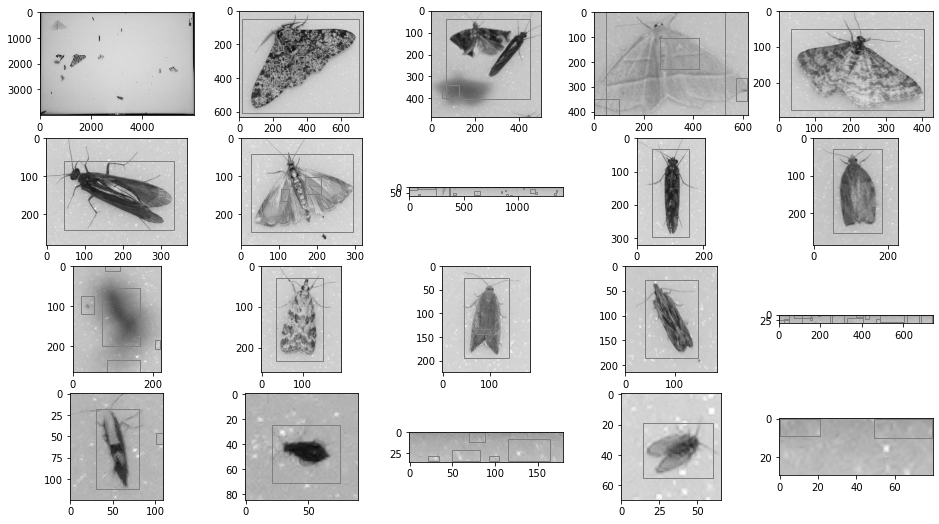

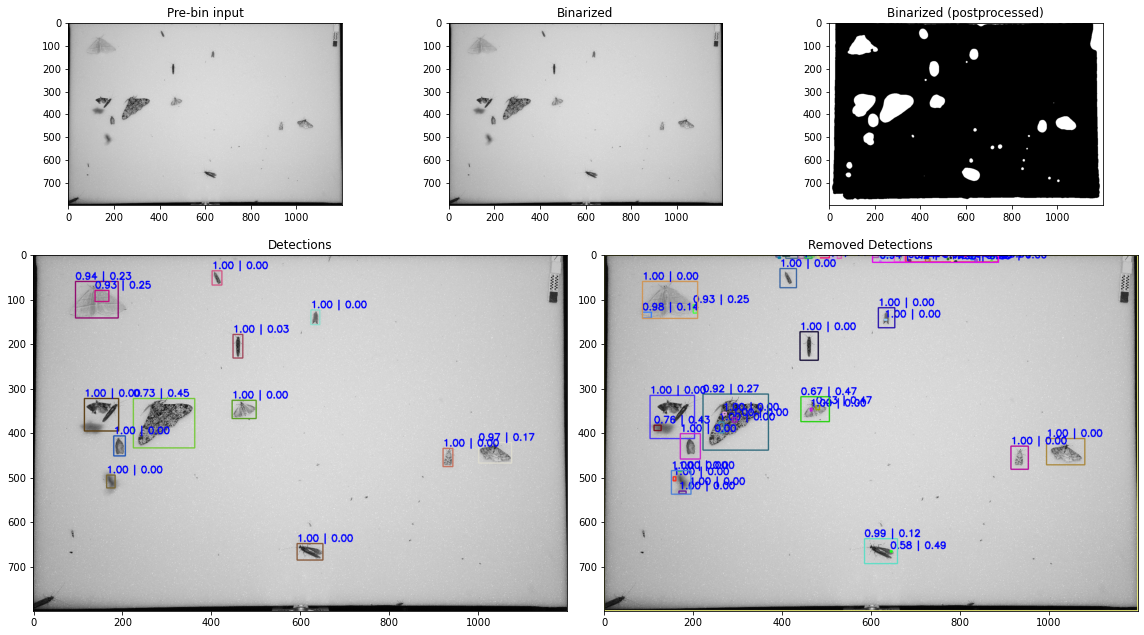

(4000, 6000)


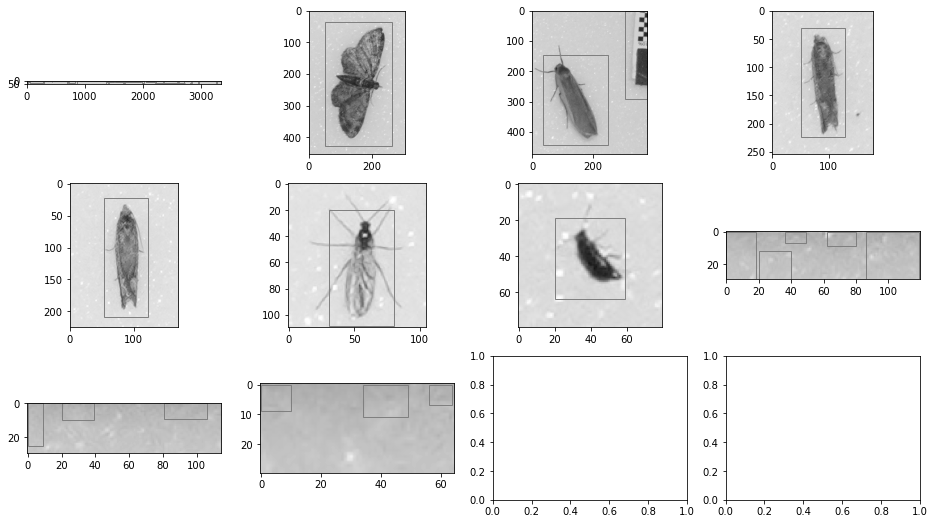

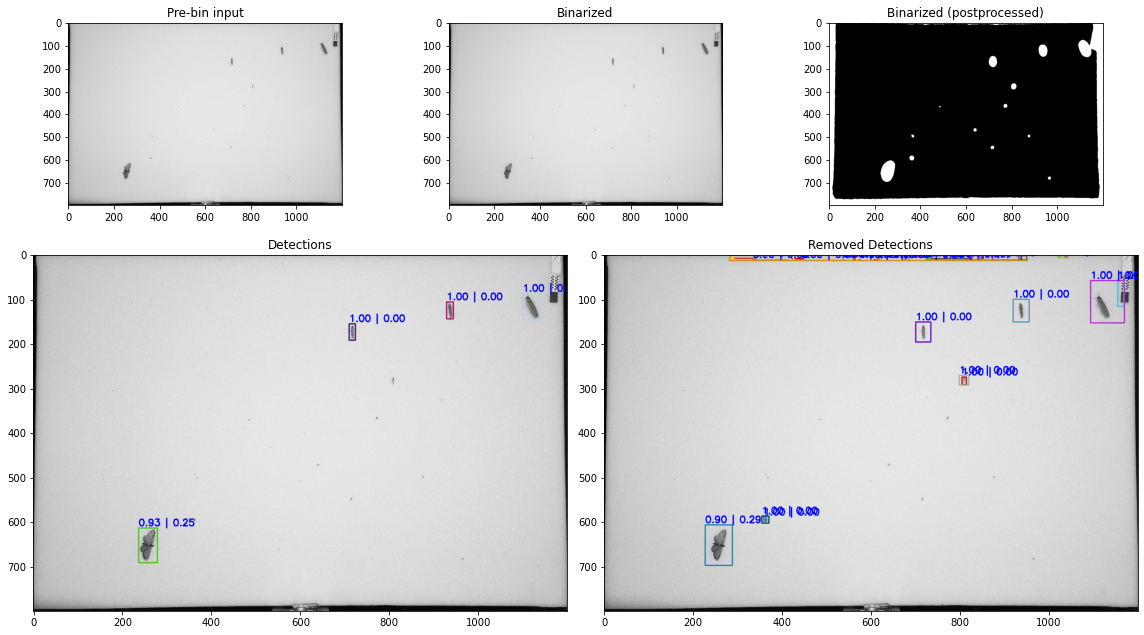

(4000, 6000)


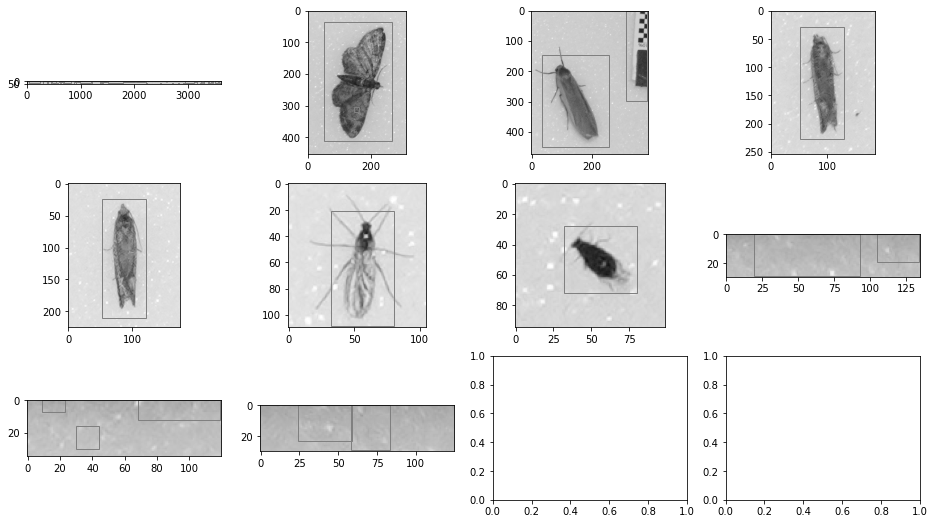

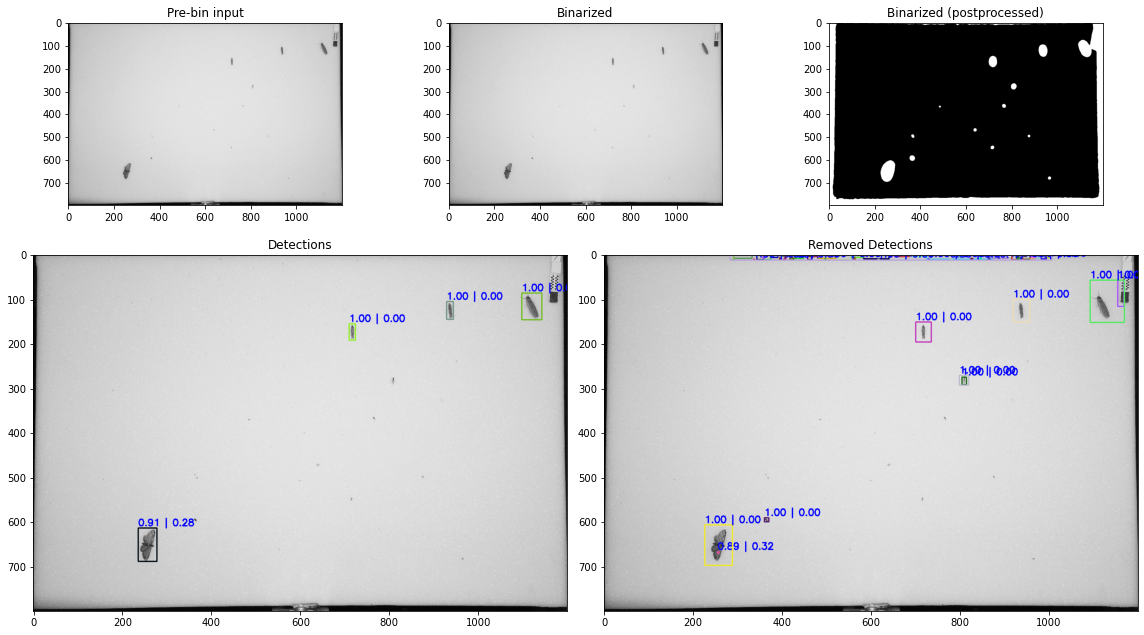

In [135]:
args = Args(
    scale=0.1,
    
    dilate_iterations=3,
    
    # high_pass otsu gauss_local
    thresholding="high_pass",
    
    location="brehm/2021-06-22_Weinschale-Ziegenhain",
#     location="brehm/2020-08-08_Strommast-Hahnengrund",
#     location="MCC/MCC_raw/val",
    
    equalize=False,
    sigma=-1,
    enlarge=-1,
    
    block_size_scale=0.2,
    pad=False,
)
print(args)

# import os
# print("\n".join(sorted(os.listdir(args.root / "brehm"))))

main(args, N=3)